In [1]:
import regex as re
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt 

In [2]:
# Load the provided test data
data_df = pd.read_csv('../data/part_10.csv')
# Drop duplicate rows right away
data_df.drop_duplicates(inplace=True)

In [3]:
# Check on the data columns
data_df.columns

Index(['CLIENT_IP', 'CLIENT_USERAGENT', 'REQUEST_SIZE', 'RESPONSE_CODE',
       'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME',
       'MATCHED_VARIABLE_VALUE', 'EVENT_ID'],
      dtype='object')

In [4]:
# Get the data description
info_df = data_df.describe(include = 'all')
info_df.loc['count NaN'] = data_df.isnull().sum()
display(info_df)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
count,57832,57517,57794,57770,57730,53167,57683,57666
unique,24940,6992,5758,60,21,3209,57611,54410
top,217.175.140.69,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,259,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height...",cr1nJWQB5cBXmMW1hh_4
freq,11286,2117,261,25771,20812,11165,28,7
count NaN,1,316,39,63,103,4666,150,167


In [5]:
# Infer the best data types
data_df = data_df.convert_dtypes()
# Check on the column types
data_df.dtypes

CLIENT_IP                 string
CLIENT_USERAGENT          string
REQUEST_SIZE              string
RESPONSE_CODE             string
MATCHED_VARIABLE_SRC      string
MATCHED_VARIABLE_NAME     string
MATCHED_VARIABLE_VALUE    string
EVENT_ID                  string
dtype: object

In [6]:
# Adjust column types, convert the int columns into floats for now as there are NaN values
INT_COLUMNS = ['REQUEST_SIZE', 'RESPONSE_CODE']

# Do the safe conversion to float/nan make sure the values are integers
# Note that, both int columns are not controlled by the client and thus
# if we have invalid valus in them it is safe to put them to NaN as such
# invalid values are a likely indicator of improperly collected data
def float_converter(val):
    try:
        result = np.nan if pd.isna(val) else int(val)
    except ValueError:
        result = np.nan
    return result

for col_name in INT_COLUMNS:
    print(f'Converting column: "{col_name}" values to float type')
    data_df[col_name] = data_df[col_name].apply(float_converter)

STRING_COLUMNS = ['CLIENT_IP', 'CLIENT_USERAGENT', 'MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME', 'MATCHED_VARIABLE_VALUE', 'EVENT_ID']
for col_name in STRING_COLUMNS:
    data_df[col_name] = data_df[col_name].astype('string')

# Check on the column types
data_df.dtypes

Converting column: "REQUEST_SIZE" values to float type
Converting column: "RESPONSE_CODE" values to float type


CLIENT_IP                  string
CLIENT_USERAGENT           string
REQUEST_SIZE              float64
RESPONSE_CODE             float64
MATCHED_VARIABLE_SRC       string
MATCHED_VARIABLE_NAME      string
MATCHED_VARIABLE_VALUE     string
EVENT_ID                   string
dtype: object

In [7]:
# Ignore the events with unset event id, it should be safe as that data is set by the server side
data_df = data_df[data_df['EVENT_ID'].notna()]

In [8]:
# Now convert the float columns into int and drop the NaN values,
# it is safe since these columns data is filled by the server side
for col_name in INT_COLUMNS:
    data_df = data_df[data_df[col_name].notna()]
    data_df[col_name] = data_df[col_name].astype('int')
    print(f'Column "{col_name}" min value is: {data_df[col_name].min()}, max values is: {data_df[col_name].max()}')

Column "REQUEST_SIZE" min value is: 15, max values is: 10529650
Column "RESPONSE_CODE" min value is: 0, max values is: 504


In [9]:
# Make sure there is no NaN values in string columns, make replacements
data_df[STRING_COLUMNS] = data_df[STRING_COLUMNS].fillna(value='')

In [10]:
# Check on the column types
data_df.dtypes

CLIENT_IP                 string
CLIENT_USERAGENT          string
REQUEST_SIZE               int64
RESPONSE_CODE              int64
MATCHED_VARIABLE_SRC      string
MATCHED_VARIABLE_NAME     string
MATCHED_VARIABLE_VALUE    string
EVENT_ID                  string
dtype: object

In [11]:
# Count the NaN values in the resulting df for sanity
data_df.isnull().sum()

CLIENT_IP                 0
CLIENT_USERAGENT          0
REQUEST_SIZE              0
RESPONSE_CODE             0
MATCHED_VARIABLE_SRC      0
MATCHED_VARIABLE_NAME     0
MATCHED_VARIABLE_VALUE    0
EVENT_ID                  0
dtype: int64

In [12]:
# Check on the data head
data_df.head(10)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
0,188.138.92.55,,166,404,REQUEST_URI,,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu
1,93.158.215.131,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,431,302,REQUEST_GET_ARGS,url,http://www.galitsios.gr/?option=com_k2,AVdcJmIIq1Ppo9zF2YIp
2,176.123.240.64,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,395,403,REQUEST_PATH,,"/opinion/page1_3.php\"" and \""\""x\""\""=\""\""x\""",iz7SN2YBrgKk_RFNZW_U
3,73.78.81.63,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,387,302,REQUEST_GET_ARGS,url,http://thereviewgroup.org/boss-capital/,AVdjekw4q1Ppo9zF6QT2
4,66.102.9.44,Mozilla/5.0 (Linux; Android 4.4.2; GT-N7100 Bu...,1733,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516288084140,SqQGI2QB5cBXmMW1CDbp
5,79.183.87.247,Mozilla/5.0 (Linux; Android 6.0; LG-H815 Build...,682,404,REQUEST_HEADERS,REQUEST_HEADERS.User-Agent,Mozilla/5.0 (Linux; Android 6.0; LG-H815 Build...,nFzwHGQB5cBXmMW1y_TD
6,88.198.201.245,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1031,302,REQUEST_GET_ARGS,REQUEST_GET_ARGS.rid,3585221644,9KP-ImQB5cBXmMW1yeXY
7,77.72.142.170,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,763,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,214296569,97JpJGQB5cBXmMW1WqBh
8,94.50.192.153,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,3786,404,REQUEST_METHOD\';\'REQUEST_CONTE,,POST\';\'multipart/form-data; boundary=----Web...,irs7_mMBjksgoq1eoQ7a
9,83.246.141.54,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,840,404,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,51660445,g4RdIGQB5cBXmMW10nGg


In [13]:
############################################################
# Now let us look at the columns to figure out which ones
# might be of use and if additional columns may be added
############################################################

In [14]:
#----------------------------------------------------------
# Consider the CLIENT_IP column

In [15]:
# Check on the IP addresses distribution
ip_counts_df = data_df['CLIENT_IP'].value_counts()
ip_counts_df.head(10)

217.175.140.69     11286
37.46.129.136        771
5.143.231.38         757
192.168.100.63       748
188.43.52.163        704
185.26.112.50        687
62.168.244.229       542
103.208.220.130      303
185.70.104.11        280
178.236.141.227      214
Name: CLIENT_IP, dtype: Int64

<AxesSubplot: >

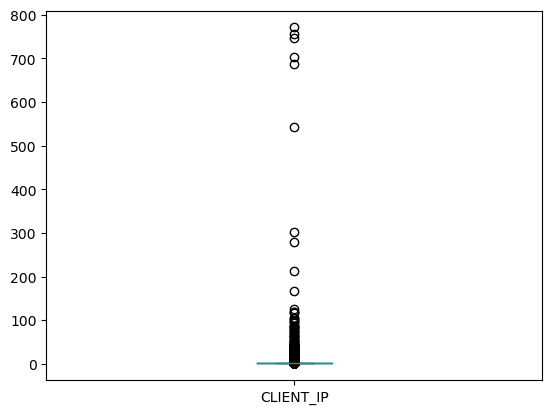

In [16]:
# Plot the the IP counts other than for '217.175.140.69'
MAX_COUNT_IP = ip_counts_df.index[0]
ip_counts_df[ip_counts_df.index != '217.175.140.69'].plot.box()

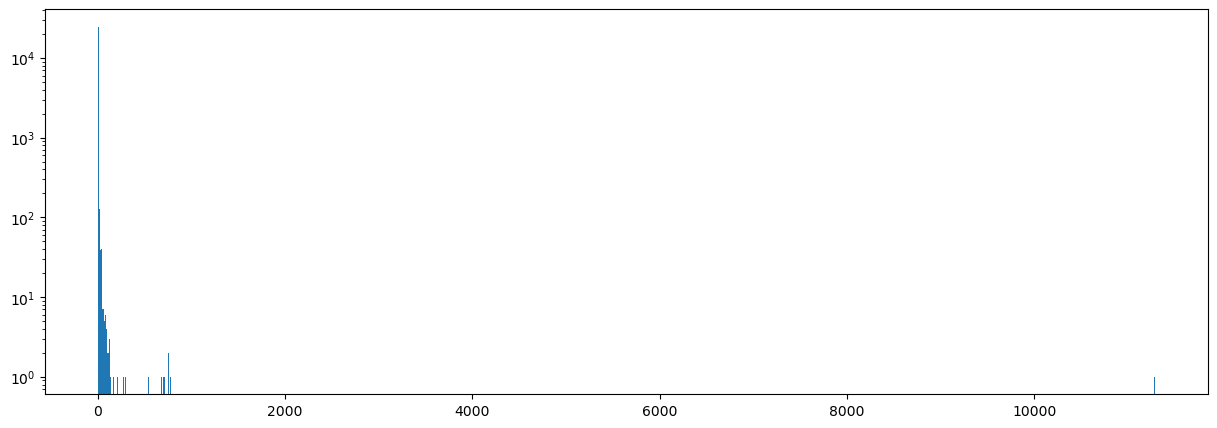

In [17]:
# Show the distribution of request counts per IP address (x-axis)
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.hist(ip_counts_df, log=True, bins=1000)

In [18]:
# The number of requests from the IP '217.175.140.69' is a clear outlier
max_ip_count = ip_counts_df.loc[MAX_COUNT_IP]
print(f'About {round(max_ip_count*100/len(data_df), 2)}% ({max_ip_count}/{len(data_df)}) of all requests are done from IP: "{MAX_COUNT_IP}"')

About 19.57% (11286/57666) of all requests are done from IP: "217.175.140.69"


In [19]:
# Check on the requests done from that IP
max_count_ip_df = data_df[data_df['CLIENT_IP'] == MAX_COUNT_IP]
max_count_ip_df.head(10)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
11,217.175.140.69,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,735,302,REQUEST_COOKIES,REQUEST_COOKIES.user_id,4f1a4c5f-9636-4e6d-9713-b94a7e22cbb0,YXqIH2QB5cBXmMW1PQw-
15,217.175.140.69,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,551,304,REQUEST_HEADERS,REQUEST_HEADERS.If-Modified-Since,"Thu, 25 Jan 2018 07:17:06 GMT",wm-kHmQB5cBXmMW1NATt
17,217.175.140.69,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,2277,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.callback_uid,2c42dc598cf3ff,mV0PHWQB5cBXmMW1Nuon
21,217.175.140.69,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,680,302,REQUEST_GET_ARGS,REQUEST_GET_ARGS.r,//dmg.digitaltarget.ru/1/224/i/i?a=224&e=5a65a...,Oq8KJGQB5cBXmMW1vQVL
27,217.175.140.69,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,4660,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.q,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height...",D759JWQB5cBXmMW1Lw0r
28,217.175.140.69,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,3007,502,REQUEST_GET_ARGS,REQUEST_GET_ARGS.callback_uid,1715ca8ec91592a,NbkMJWQB5cBXmMW1VVhF
39,217.175.140.69,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,3795,307,REQUEST_COOKIES,REQUEST_COOKIES.rpx,"31956=70895,0,1,,&6286=70686,0,1,,&106496=7085...",QIEmIGQB5cBXmMW1qsEs
41,217.175.140.69,*BgfBAAAA-EAAAEFBAAQLljjU6Vfh4i4fw0IhLFvB2RNU3...,218,200,REQUEST_PATH,REQUEST_PATH,/updates/kdb/i386/diffs/base087e.kdc.ply,_lPZG2QB5cBXmMW1csGr
43,217.175.140.69,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,3002,302,REQUEST_COOKIES,REQUEST_COOKIES.KRTBCOOKIE_561,9455-uid:076313ed-38b6-47d3-9c7d-e7278703aaae,smO3HWQB5cBXmMW1V7UQ
53,217.175.140.69,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,2831,200,REQUEST_COOKIES,REQUEST_COOKIES.icu,ChgI44kuEAoYFyAXKBcw-6fA0wU4F0AXSBcKGAjLpDMQCh...,OrfZJGQB5cBXmMW1kyE-


In [20]:
# Check on the IP address values as well, we expect IP4 and IP6 addresses
unique_client_ips = data_df['CLIENT_IP'].unique()

def check_ip_pattern(ip_values, reg_exp, version):
    good_ip_values = {ip_val for ip_val in ip_values if reg_exp.match(ip_val.upper())}
    print(f'There are: {len(good_ip_values)} distinct GOOD IPv{version} values present, which is {round(len(good_ip_values)*100/len(ip_values), 2)} %!')
    return good_ip_values

# Check on IPv4, reg-exp source from: 
#    https://www.oreilly.com/library/view/regular-expressions-cookbook/9780596802837/ch07s16.html
ip_v4_reg_exp = re.compile(r'^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')
good_ip_v4 = check_ip_pattern(unique_client_ips, ip_v4_reg_exp, 4)

# Check on IPv6, reg-exp source from:
#    https://www.oreilly.com/library/view/regular-expressions-cookbook/9781449327453/ch08s17.html
ip_v6_reg_exp = re.compile(r'^(?:[A-F0-9]{1,4}:){7}[A-F0-9]{1,4}$')
good_ip_v6 = check_ip_pattern(unique_client_ips, ip_v6_reg_exp, 6)

# Log the malformed unique IP values
malformed_ips = [ip_val for ip_val in unique_client_ips if ip_val not in good_ip_v4 and ip_val not in good_ip_v6]
print(f'The unique malformed IP values are:\n{malformed_ips}')

There are: 24794 distinct GOOD IPv4 values present, which is 99.74 %!
There are: 23 distinct GOOD IPv6 values present, which is 0.09 %!
The unique malformed IP values are:
['2001:4ba0:cafe:ace::1', '2a01:598:9902:df0c:8115:691e:c38', '2a01:4f8:171:3299::2', '2a02:750:5::9c5', '2a02:27aa::68b', '2a01:4f8:212:457::2', '2001:7d0:87e2:1480:e870:b625:397', '2a01:4f8:212:284c::2', '2a01:4f8:201:5009::2', '2a02:2168:13cb:4300:b5d0:78ec:8d', '2a01:4f8:212:45d::2', '2a00:1148:b0ba:2615:8b4:f98f:f56', '2001:730:3e18:6000::3f', '2a01:4f8:162:1129::2', '2a02:6b8:0:c2e::9', '2a01:4f8:c17:d8d::2', '2a02:2698:3c23:65d4:1839:9c8f:ef', '2a02:2698:7c25:f4dc:409e:83aa:61', '2a00:1370:812a:1379:3d16:a3b4:88', '2a03:6f00:1:1::bce1:1152', '2001:41d0:52:a00::2b', '2a02:2168:d84:ec00:54d3:8341:440', '2a02:c7d:1171:8300:2980:a4b7:4f9', '2a02:2698:7022:939a:c473:f721:9d', '2001:41d0:8:d744::1', '2a02:598:a::78:166', '2a01:4f8:212:451::2', '2001:41d0:a:6097::', '2a02:2168:817:621::2', '2a02:2168:f55:1b00:c589:66

In [21]:
# Add a new distinct column indicating the validity of the IP address
data_df['IS_CLIENT_IP_VALID'] = data_df['CLIENT_IP'].apply(lambda ip_value: ip_value in good_ip_v4 or ip_value in good_ip_v6)

In [22]:
# CLIENT_IP column conclusion:
#    Is useful as too many requests from the same IP address can be
#    a sign of an attack, also a malformed IP can be a sign of an attack
#----------------------------------------------------------

In [23]:
#----------------------------------------------------------
# Consider the CLIENT_USERAGENT column

In [24]:
# List the unique user agents used from the IP address from which the maximum number of requests came
unique_agent_values_mci = max_count_ip_df['CLIENT_USERAGENT'].unique()
print(f'There are {len(unique_agent_values_mci)} distinct user agent values for IP: "{MAX_COUNT_IP}", namely:\n{unique_agent_values_mci}')

There are 557 distinct user agent values for IP: "217.175.140.69", namely:
<StringArray>
[                                                                                                                                                                                                                                                                       'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36',
                                                                                                                                                                                                                                                                        'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2623.112 Safari/537.36',
                                                                                                                                                                           

In [25]:
# List the unique user agents used from All the IP addresses
unique_agent_values_all = data_df['CLIENT_USERAGENT'].unique()
print(f'There are {len(unique_agent_values_all)} distinct user agent values for All requests')

There are 6949 distinct user agent values for All requests


In [26]:
# According to:
#    https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/User-Agent
# The valid user agent value value shall be:
#    User-Agent: <product> / <product-version> <comment>
# Common format for web browsers:
#    User-Agent: Mozilla/5.0 (<system-information>) <platform> (<platform-details>) <extensions>
# Let us take the user agent regexp from:
#    https://regex101.com/library/2McsiK
user_agent_reg_exp = re.compile(r'\((?<info>.*?)\)(\s|$)|(?<name>.*?)\/(?<version>.*?)(\s|$)')
broken_agent_values_all = [user_agent for user_agent in unique_agent_values_all if not user_agent_reg_exp.match(user_agent)]
print(f'There are: {len(broken_agent_values_all)} distinct malformed user agent values present, which is {round(len(broken_agent_values_all)*100/len(unique_agent_values_all), 2)} %!')

There are: 596 distinct malformed user agent values present, which is 8.58 %!


In [27]:
# Check on the percent of malformed user agent values for maximum count IP:
broken_agent_values_mci = [user_agent for user_agent in unique_agent_values_mci if not user_agent_reg_exp.match(user_agent)]
print(f'There are: {len(broken_agent_values_mci)} distinct malformed user agent values for IP: "{MAX_COUNT_IP}" present, which is {round(len(broken_agent_values_mci)*100/len(unique_agent_values_mci), 2)} %!')

There are: 337 distinct malformed user agent values for IP: "217.175.140.69" present, which is 60.5 %!


In [28]:
# Extend data with the validity flag for the user agent as it may be a good indicator of the attack
# The percent of malformed user agent values is significantly higher for the IP from which most requests came
data_df['IS_USERAGENT_VALID'] = data_df['CLIENT_USERAGENT'].apply(lambda user_agent: user_agent_reg_exp.match(user_agent))

In [29]:
# CLIENT_USERAGENT column conclusion:
#    Is useful, as malformed user agents can be a sign of an attack
#    Also, using multiple clients from the same IP address or a
#    specific user agent type used.
#----------------------------------------------------------

In [30]:
#----------------------------------------------------------
# Consider the REQUEST_SIZE column

<AxesSubplot: >

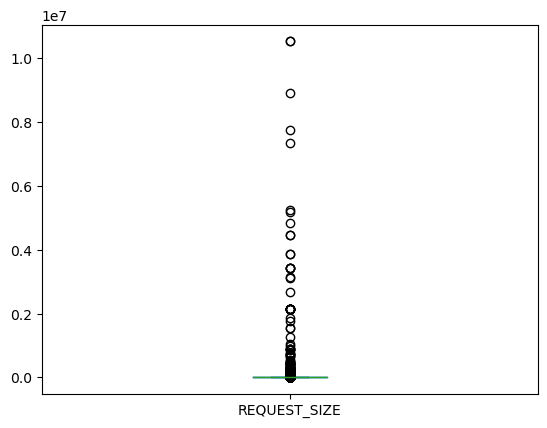

In [31]:
# Check on the distribution of the request sizes, there are clear outliers here
# The request sizes go up to 10 megabytes which may be an indicator of an attack
data_df['REQUEST_SIZE'].plot.box()

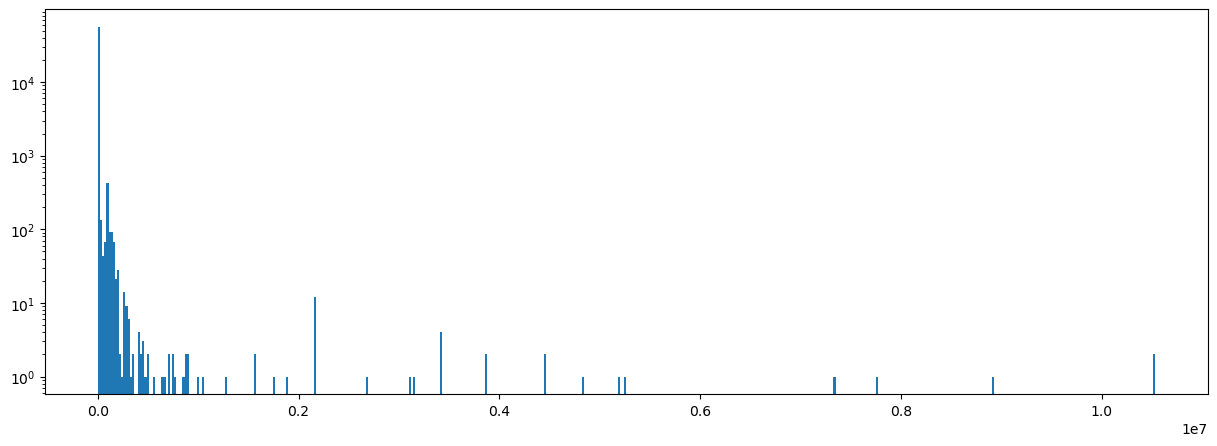

In [32]:
# Given most of the requests are small
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.hist(data_df['REQUEST_SIZE'], log=True, bins=500)

In [33]:
# REQUEST_SIZE column conclusion:
#    Is useful, as too little or too much request data can be a sign of an attack.
#---------------------------------------------------------

In [ ]:
#----------------------------------------------------------
# Consider the RESPONSE_CODE column

In [ ]:
# RESPONSE_CODE column conclusion:
#    Is ...
#---------------------------------------------------------

In [ ]:
#----------------------------------------------------------
# Consider the MATCHED_VARIABLE_SRC column

In [ ]:
# MATCHED_VARIABLE_SRC column conclusion:
#    Is ...
#---------------------------------------------------------

In [ ]:
#----------------------------------------------------------
# Consider the MATCHED_VARIABLE_NAME column

In [ ]:
# MATCHED_VARIABLE_NAME column conclusion:
#    Is ...
#---------------------------------------------------------

In [ ]:
#----------------------------------------------------------
# Consider the MATCHED_VARIABLE_VALUE column
#
# MATCHED_VARIABLE_VALUE column conclusion:
#    Is not useful as the actul value 
#---------------------------------------------------------

In [ ]:
#----------------------------------------------------------
# Consider the EVENT_ID column

In [47]:
# Check on the EVENT_ID distinct value counts, we see there are some duplicates
event_id_df = data_df['EVENT_ID'].value_counts()
event_id_df.head(10)

cr1nJWQB5cBXmMW1hh_4    7
XZ-bImQB5cBXmMW11ksX    6
l1mUHGQB5cBXmMW1mdYm    6
m1K7G2QB5cBXmMW1pcnY    6
dqqPI2QB5cBXmMW1L9-m    5
znQRH2QB5cBXmMW1_Hsj    5
2pJ_IWQB5cBXmMW1IzTz    4
f1vOHGQB5cBXmMW1FsSB    4
tJ6JImQB5cBXmMW1mnrP    4
7FzeHGQB5cBXmMW1M1VQ    4
Name: EVENT_ID, dtype: Int64

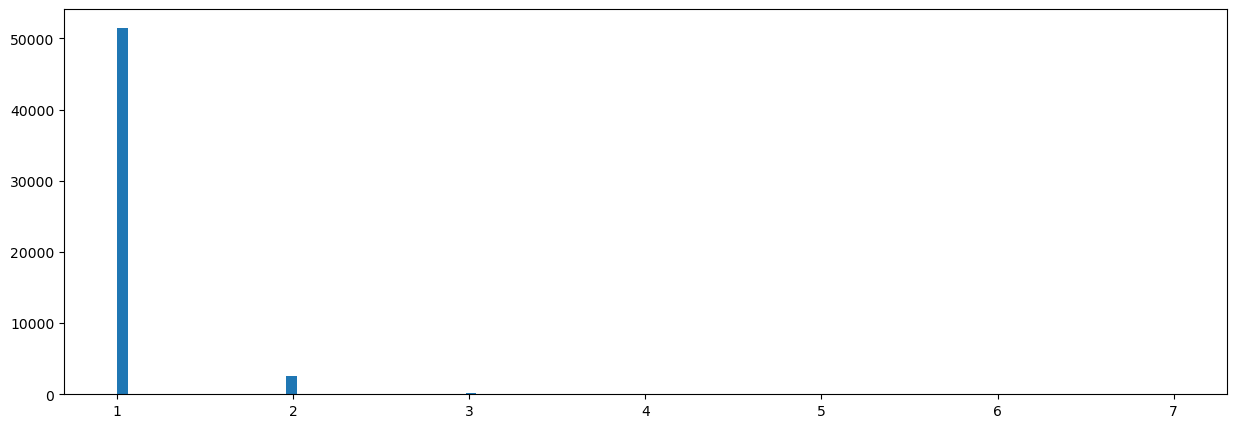

In [49]:
# Most event ids are not duplicated
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.hist(event_id_df, bins=100)

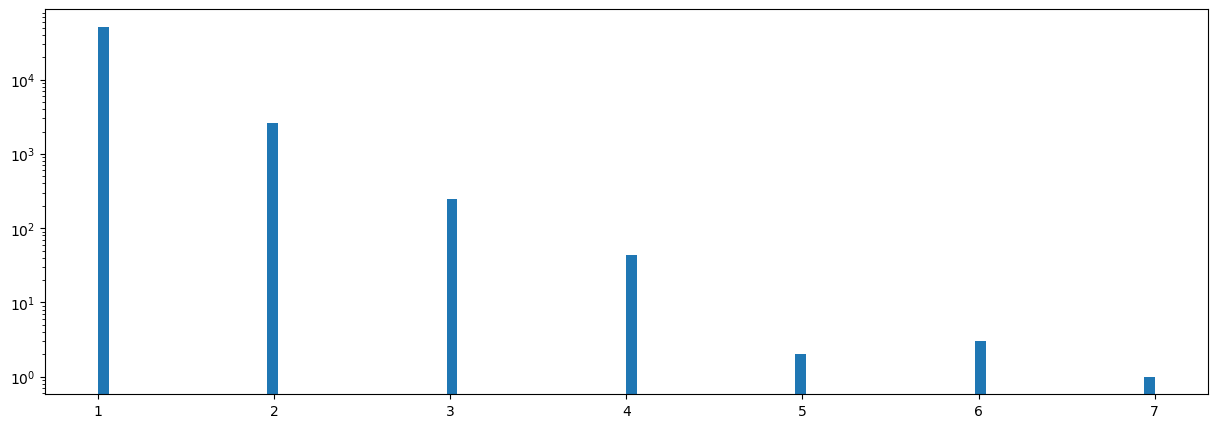

In [57]:
# In the log scale we see some duplication, yet the event id values are
# expected to be unique but as they seem to be constructed hashes values
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.hist(event_id_df, log=True, bins=100)

In [56]:
# The following percent of event ids are not unique
u_evt_id = np.sum(event_id_df == 1)
print(f'There are {u_evt_id}/{len(data_df)} events with unique event ids')
d_evt_id = np.sum(event_id_df > 1)
print(f'There are {d_evt_id}/{len(event_id_df)} repeating event ids')

There are 51512/57666 events with unique event ids
There are 2898/54410 repeating event ids


In [ ]:
# EVENT_ID column conclusion:
#    Is not useful for the attack detection as it is supposed
#    to be assigned uniquely for each individual event.
#---------------------------------------------------------